In [16]:
####Run this block first to initiate functions############
##no input needed in this block##

#import libraries
import numpy as np
import matplotlib.pyplot as plt
import time

#define implicit method function
def implicit(init_grid,FO,N,m):
    #Set length of coefficient matrix for looping
    M = (m+1)**2
    nx = m+1
    #create coefficient matrix of zeroes to start
    A = np.zeros([(m+1)**2,(m+1)**2])
    #counter
    k = 0
    while k<M-1:
        #set boundary conditions with set values
        if k == 0:
            A[k,k] = 1
        elif (k>=1) and (k<=nx):
            A[k,k] = 1
        elif k > nx*(nx-1):
            A[k,k] = 1
        elif k%nx == 0:
            A[k,k] = 1
        #insulated boundary condition    
        elif (k+1)%(nx) == 0:
            A[k,k-1] = -FO
            A[k,k+nx] = -FO
            A[k,k-nx] = -FO
            A[k,k] = (1+3*FO)
        #interior nodes
        else:
            A[k,k+1] = -FO
            A[k,k-1] = -FO
            A[k,k+nx] = -FO
            A[k,k-nx] = -FO
            A[k,k] = (1+4*FO)
        k+=1
    
    #flatten original matrix for 'k' references
    temperature_grid_n = init_grid.copy().flatten()
    #create inverse of A for solving linear algebra equations
    A =(np.linalg.pinv(A))
    
    #start at time step 1
    n = 1
    #loop through all time steps in set run time
    while n<=N:       
        #solve for unknown matrix B
        temperature_grid_nplus1 = np.matmul(A,temperature_grid_n)
        #reset boundary nodes except insulated boundary
        k = 0
        while k<M-1:
            if k == 0:
                temperature_grid_nplus1[k] = 0
            elif (k>=1) and (k<nx):
                temperature_grid_nplus1[k] = 100
            elif k > nx*(nx-1):
                temperature_grid_nplus1[k] = 0
            elif k%nx == 0:
                temperature_grid_nplus1[k] = 0    
            k+=1
        temperature_grid_nplus1[-1] = 0    
        #find difference in temperatures for steady state checks
        diff = temperature_grid_nplus1 - temperature_grid_n
        #set n+1 values to n values for next look
        temperature_grid_n = temperature_grid_nplus1.copy()
        
        #check for steady state
        if diff.max()<=1e-5:
            break
        else:
            n+=1
    #reshape final temperatures into mxm grid
    end_grid = temperature_grid_nplus1.copy().reshape([m+1,m+1])
    
    return end_grid,n, diff

#define explicit method function
def explicit(init_grid,FO,N):
    #stability flag
    unstable = False
    #set n_grid to intial grid
    n_grid = init_grid
    #set n to first time step out 
    n = 1
    N_diff = []
    #define midpoint reference
    mid = int((m+1)/2)
    #start the loop
    while n<=N:
        #set temperature_grid_n equal to old grid for calculations
        temperature_grid_n = n_grid.copy()
        #set temperature_grid_nplus1 equal to old grid for reassignment
        temperature_grid_nplus1 = n_grid.copy()
        #set i and j to start at first interior nodes
        i = 1
        while i<=m-1:
            j = 1
            while j<=m:
                #interior node equations
                if j == m:
                    Temperature_nplus1 = FO*(temperature_grid_n.item(i,j-1)+
                                             temperature_grid_n.item(i-1,j)+
                                             temperature_grid_n.item(i+1,j)-
                                             3*temperature_grid_n.item(i,j)) + temperature_grid_n.item(i,j)
                    temperature_grid_nplus1[i,j] = Temperature_nplus1
                    j+=1
                #insulated boundary equations
                else:                
                    Temperature_nplus1 = FO*(temperature_grid_n.item(i+1,j)+
                                             temperature_grid_n.item(i-1,j)+
                                             temperature_grid_n.item(i,j-1)+
                                             temperature_grid_n.item(i,j+1)-
                                             4*temperature_grid_n.item(i,j)) + temperature_grid_n.item(i,j)
                    temperature_grid_nplus1[i,j] = Temperature_nplus1
                    j+=1
            i+=1
        #difference matrix for stability and steady state checks
        diff = temperature_grid_nplus1 - n_grid
        #creating list of mid-grid values for plotting
        N_diff.append(temperature_grid_nplus1[mid,mid])
        #set new grid to n grid for next iteration
        n_grid = temperature_grid_nplus1.copy()
        
        #check for stability, flatten matrix for easier handling
        diff_check = diff.copy().flatten()
        #check each difference value for a negative number, if negative set unstable to True, report time model went unstable
        if [x for x in diff_check if x<0]:
            print('Model is unstable at current time step. \nInstability reached at time {:.3} seconds.'.format(n*FO*(1/m)**2/alpha))
            unstable = True
            break
        #check if steady state has been acheived
        if diff.max()<=1e-4:
            break
        else:
            n+=1
        n+=1
    return n_grid,n,N_diff,unstable
    
#define main function
def _main(m,alpha,method,time_run,time_step,FO):    
    #intialize the grid with initial Temperature conditions at n=0
    print('Grid size '+str(m)+'x'+str(m))
    initial_grid = np.zeros([m+1,m+1])
    initial_grid[0,1:m+1] = 100
    #Set delx with grid size, assign ystep=xstep to show uniform grid
    x_step = y_step = 1/m
    #Assign time step
    if time_step:
        FO = alpha*time_step/x_step**2
        print('FO : {}'.format(FO))

    if not time_step:
        time_step = FO*x_step**2/alpha
        print('Time step : {:.6} seconds'.format(time_step))
    
    #Calculate Fourier number (FO)
    N = time_run/time_step
    if method == 'Explicit':
        final_grid,N_end,diff,unstable = explicit(initial_grid,FO,N)        
        #calculate steady state time
        ss_time = N_end*time_step 
        if N_end < N:
            if not unstable:
                print('Steady state reached at Time = {:.3} seconds'.format(N_end*time_step))
        else:
            print('Steady state not reached')
    if method == 'Implicit':
        final_grid,N_end,diff = implicit(initial_grid,FO,N,m)
        #calculate steady state time
        ss_time = N_end*time_step 
        if N_end < N:
            print('Steady state reached at Time = {:.3} seconds'.format(N_end*time_step))
        else:
            print('Steady state not reached')
    
    #make line for cleaner print statements
    print(40*'*'+'\n')
    #return final temperature grid 
    return final_grid  


In [17]:
####Change variables here and run block to set variables####### 

alpha_var = 1.0
method_var = 'Explicit' #'Explicit' #'Implicit' <--choose one, copy and paste
time_step_var = '' #<-- #can be set or left as is
time_run_var = 1.8 #<-- #vary to see 0.05 s results, currently at ss time
FO_var = .25 #<-- #can be varied, will compute time step



Grid size 10x10
Time step : 0.0025 seconds
Steady state reached at Time = 1.62 seconds
****************************************

Grid size 20x20
Time step : 0.000625 seconds
Steady state reached at Time = 1.39 seconds
****************************************

Grid size 40x40
Time step : 0.00015625 seconds
Steady state reached at Time = 1.16 seconds
****************************************



Text(0, 0.5, 'Mid y-axis Temperatures')

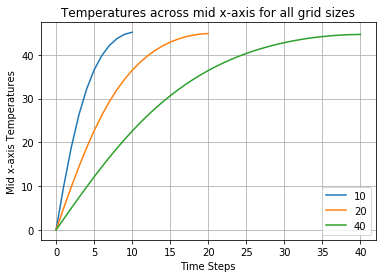

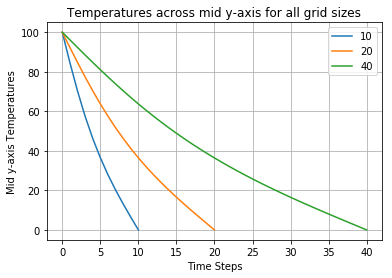

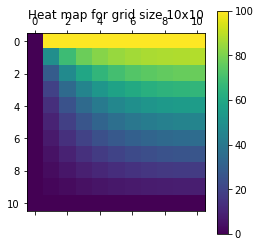

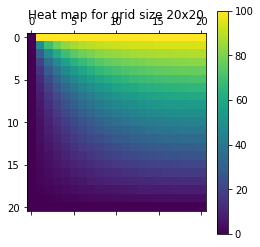

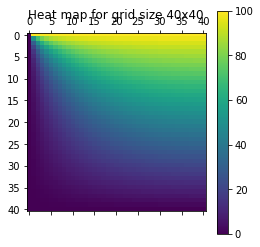

In [18]:
#### Run this block last to execute ###

plt.close('all')
#grid sizes, will loop through this list
steps = [10,20,40]
#lists for plot legends and time
grids = []
times = []

#initiate x-axis and y-axis plots
fig1, ax1 = plt.subplots()
ax1.set_title('Temperatures across mid x-axis for all grid sizes')
fig2, ax2 = plt.subplots()
ax2.set_title('Temperatures across mid y-axis for all grid sizes')

for step in steps:
    grids.append(step)
    m = step #m is the grid size for both axes
    alpha = alpha_var
    method = method_var #'Explicit' #'Implicit'
    time_step = time_step_var
    time_run = time_run_var
    FO = FO_var
    
    now = time.time()
    final_grid = _main(m,alpha,method,time_run,time_step,FO)
    #print('Time to run model : {:.3}'.format(time.time()-now)) <-this doesn't work right in jupyter notebook?
    
    #plot heatmap for each grid
    plt.matshow(final_grid)
    plt.colorbar()
    plt.title('Heat map for grid size {}x{}'.format(step,step))
    
    #plot x- and y- axis plots
    ax1.plot(final_grid[int(step/2),:])
    ax2.plot(final_grid[:,int(step/2)])    
    


#format plots
ax1.grid(True)
ax1.legend(grids)
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Mid x-axis Temperatures') 

ax2.grid(True)
ax2.legend(grids)
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Mid y-axis Temperatures')      